# Lesson 1 - What's your pet

---
For future reference:

If you go to [fastai/fastai_docs](https://github.com/fastai/fastai_docs) and click on [docs/src](https://github.com/fastai/fastai_docs/tree/master/docs_src).

All of our documentation is actually just Jupyter Notebooks. You can git clone this repo and if you run it, you can actually run every single line of the documentation yourself.

---

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
# Create the destination path for the data
# cwd() is current working directory

datapath = Path.cwd()/'data'
datapath

PosixPath('/home/jupyter/my-fastai-notebooks/data')

In [6]:
path = untar_data(URLs.PETS, dest=datapath)
path

PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet')

In [7]:
# I think fastai gave path the ls() method

path.ls()

[PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images'),
 PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/models'),
 PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/annotations')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images/japanese_chin_125.jpg'),
 PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images/British_Shorthair_155.jpg'),
 PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images/Siamese_56.jpg'),
 PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images/Bombay_111.jpg'),
 PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images/pomeranian_11.jpg')]

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
# this is the regex that extracts the breed label from the filename without the number at the end

In [11]:
ImageDataBunch.from_name_re?

Signature:
ImageDataBunch.from_name_re(
    ['path: Union[pathlib.Path, str]', 'fnames: Collection[pathlib.Path]', 'pat: str', 'valid_pct: float = 0.2', '**kwargs'],
)
Docstring: Create from list of `fnames` in `path` with re expression `pat`.
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py
Type:      method


<br>
----------

The following will create a DataBunch of Images that are already split between training and validation sets. The labels will come from the filename, which the regex will isolate.

Transforms will be applied at random every time the data is loaded/called, due to `ds_tfms=get_transforms()`<br>
The images have to be the same shape/size 224p x 224p <br>
Batch size of 64

The data will be normalized (pixel values will have same mean and standard deviation) with `imagenet_stats` since we will be using the pretrained model

In [12]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [13]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
japanese_chin,British_Shorthair,Siamese,german_shorthaired,samoyed
Path: /home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Maine_Coon,beagle,Birman,Russian_Blue,Russian_Blue
Path: /home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/images;

Test: None

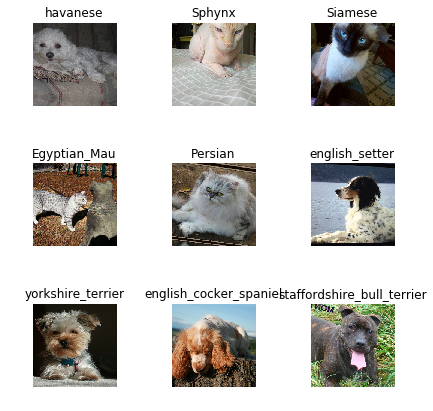

In [14]:
# Look at the data

data.show_batch(rows=3, figsize=(6,6))

In [15]:
print(f'label names (classes):\n{data.classes} \n')
print(f'number of classes: {len(data.classes)}\n')
print(data.c)

label names (classes):
['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier'] 

number of classes: 37

37


For this classification problem, `data.c` is essentially the number of classes. But in reality it means something else, which we will discuss in a later lesson

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [23]:
# Create a Learner object for a Convolutional Neural Network

learn = cnn_learner(data,               # ImageDataBunch created earlier
                    models.resnet34,    # pretrained resnet34 model/architecture
                    path=path,          # set the path where Learner will look for model directory
                    metrics=error_rate) # metrics to track/print every epoch

The first time I run this on a newly installed box, it downloads the ResNet34 pre-trained weights. What that means is that this particular model has actually already been trained for a particular task. And that particular task is that it was trained on looking at about one and a half million pictures of all kinds of different things, a thousand categories of things, using an image dataset called ImageNet. So we can download those pre-trained weights so that we don't start with a model that knows nothing about anything, but we actually start with a model that knows how to recognize a thousand categories of things in ImageNet. 

I don't think all of these 37 categories of pet breeds are in ImageNet but there were certainly some kinds of dog and some kinds of cat. So this pre-trained model knows quite a bit about what pets look like, and it certainly knows quite a lot about what animals look like and what photos look like. 

So the idea is that we don't start with a model that knows nothing at all, but we start by downloading a model that knows something about recognizing images already. So it downloads for us automatically, the first time we use it, a pre-trained model and then from now on, it won't need to download it again - it'll just use the one we've got.

In [17]:
# Display resnet34 architecture

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Train for 4 epochs

You could just use a method called `fit` but in practice, you should nearly always use a method called `fit_one_cycle`. <br>
In short, one cycle learning is a paper that was released in April and turned out to be dramatically better both more accurate and faster than any previous approach. Again, I don't want to teach you how to do 2017 deep learning. In 2018, the best way to fit models is to use something called one cycle.

Default arguments (Shift+Tab):
```python
learn.fit_one_cycle(
    ['cyc_len: int', 'max_lr: Union[float, Collection[float], slice] = slice(None, 0.003, None)', 
    'moms: Tuple[float, float] = (0.95, 0.85)', 'div_factor: float = 25.0', 'pct_start: float = 0.3', 
    'final_div: float = None', 'wd: float = None', 'callbacks: Union[Collection[fastai.callback.Callback], NoneType] = None', 
    'tot_epochs: int = None', 'start_epoch: int = None'],)
```


In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.397295,0.344938,0.100135,00:30
1,0.553981,0.308361,0.102165,00:30
2,0.329019,0.259172,0.092016,00:30
3,0.258078,0.244621,0.077131,00:31


In [25]:
learn.save('res34-stage-1', return_path=True)

PosixPath('/home/jupyter/my-fastai-notebooks/data/oxford-iiit-pet/models/res34-stage-1.pth')

So +92% of the time, we correctly picked the exact right one of those 37 dog and cat breeds, which feels pretty good to me. But to get a sense of how good it is, maybe we should go back and look at the paper. [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)

The nice thing about using academic papers or Kaggle dataset is we can compare our solution to whatever the best people in Kaggle did or in the academics did.

So in 2012, this highly pet specific analysis got an accuracy of 59%. These were the top researchers from Oxford University. Today in 2018, with basically about three lines of code, we got 92% (i.e. 8% error). So that gives you a sense of how far we've come with deep learning, and particularly with PyTorch and fastai, how easy things are.

# Visualize Results

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
# Returns Classification Interpretation object with loss info from Learner

losses,idxs = interp.top_losses()
# Returns all losses and indicies (as tensors), sorted descending (largest first)

len(data.valid_ds)==len(losses)==len(idxs)

True

In [33]:
doc(interp.plot_top_losses)

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = True , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

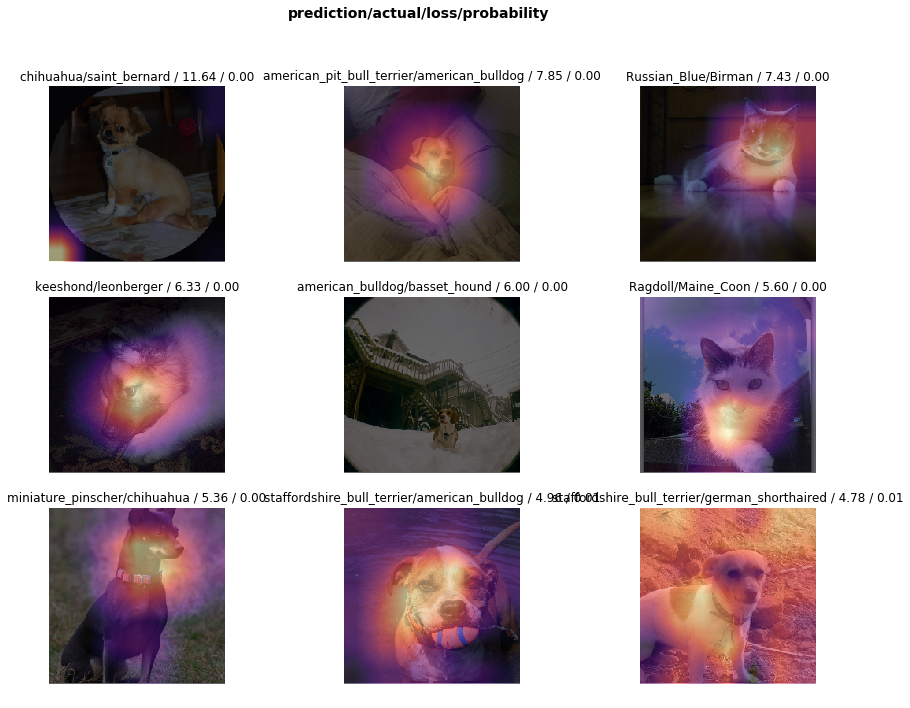

In [32]:
interp.plot_top_losses(9, figsize=(15,11))

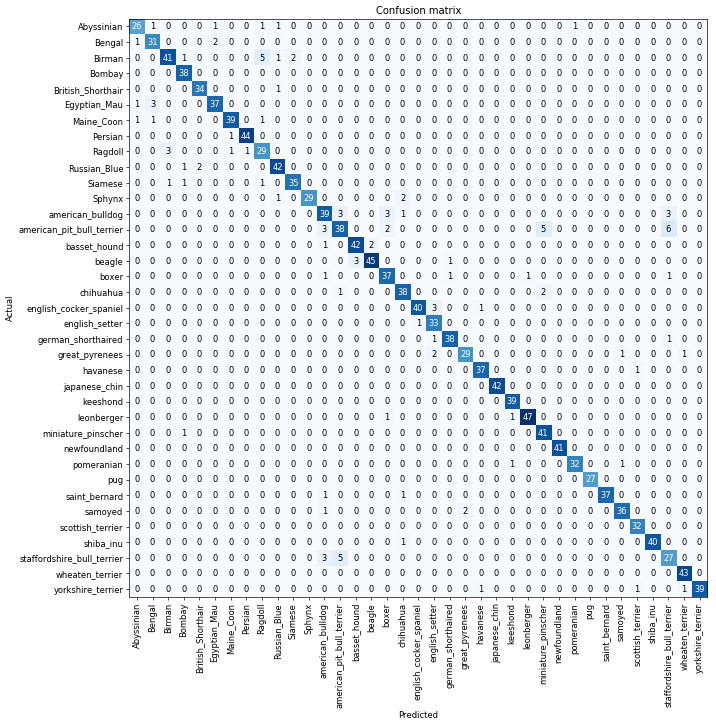

In [34]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

#### However, if you have a lot of classes, the confusion matrix can get crowed, so just examine the most confused

In [36]:
doc(interp.most_confused)

most_confused [source] [test] most_confused ( min_val : int = 1 , slice_size : int = 1 ) → Collection [ Tuple [ str , str , int ]] 
 
 × No tests found for most_confused . To contribute a test please refer to this guide and this discussion . Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences. 
 Show in docs

In [35]:
# Sorted descending list of largest non-diagonal entries of confusion matrix
# Presented as actual, predicted, number of occurrences.

interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('american_pit_bull_terrier', 'miniature_pinscher', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Ragdoll', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_bulldog', 'boxer', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('beagle', 'basset_hound', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Siamese', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('basset_hound', 'beagle', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('great_pyrenees', 'english_setter', 2),
 ('samoyed', 'great_pyrenees', 2)]

# Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

Let's make our model better by using fine-tuning. So far we fitted 4 epochs and it ran pretty quickly. The reason it ran pretty quickly is that there was a little trick we used. These convolutional networks, they have many layers. What we did was we added a few extra layers to the end and we only trained those. We basically left most of the model exactly as it was, so that's really fast. If we are trying to build a model at something that's similar to the original pre-trained model (in this case, similar to the ImageNet data), that works pretty well.

But what we really want to do is to go back and train the whole model. This is why we pretty much always use this two stage process. By default, when we call `fit` or `fit_one_cycle` on a ConvLearner, it'll just fine-tune these few extra layers added to the end and it will run very fast. It will basically never overfit but to really get it good, you have to call `unfreeze`. 


`unfreeze` is the thing that says please train the whole model. Then I can call fit_one_cycle again. 

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.513893,0.346240,0.110284,00:39


Uh-oh. The error got much worse. Why? In order to understand why, we are actually going to have to learn more about exactly what's going on behind the scenes. So let's start out by trying to get an intuitive understanding of what's going on behind the scenes. We are going to do it by looking at pictures.


[[1:16:28](https://youtu.be/BWWm4AzsdLk?t=4588)]

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson1/100.png'/>

These pictures come from [a fantastic paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) by Matt Zeiler who nowadays is a CEO of Clarify which is a very successful computer vision startup and his supervisor for his PhD Rob Fergus. They wrote a paper showing how you can visualize the layers of a convolutional neural network. A convolutional neural network, which we will learn mathematically about what the layers are shortly, but the basic idea is that your red, green, and blue pixel values that are numbers from nought to 255 go into the simple computation (i.e. the first layer) and something comes out of that, and then the result of that goes into a second layer, and the result of that goes into the third layer and so forth. There can be up to a thousand layers of neural network. 

ResNet34 has 34 layers, and ResNet50 has 50 layers, but let's look at layer one. There's this very simple computation which is a convolution if you know what they are. What comes out of this first layer? Well, we can actually visualize these specific coefficients, the specific parameters by drawing them as a picture. There's actually a few dozen of them in the first layer, so we don't draw all of them. Let's just look at 9 at random. 



[[1:17:45](https://youtu.be/BWWm4AzsdLk?t=4665)]

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson1/124.png'/>

Here are nine examples of the actual coefficients from the first layer. So these operate on groups of pixels that are next to each other. So this first one basically finds groups of pixels that have a little diagonal line, the second one finds diagonal line in the other direction, the third one finds gradients that go from yellow to blue, and so forth. They are very simple little filters. That's layer one of ImageNet pre-trained convolutional neural net. 

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson1/125.png'/>

Layer 2 takes the results of those filters and does a second layer of computation. The bottom right are nine examples of a way of visualizing one of the second layer features. AS you can see, it basically learned to create something that looks for top left corners. There are ones that learned to find right-hand curves, and little circles, etc. In layer one, we have things that can find just one line, and in layer 2, we can find things that have two lines joined up or one line repeated. If you then look over to the right, these nine show you nine examples of actual bits of the actual photos that activated this filter a lot. So in other words, the filter on the bottom right was good at finding these window corners etc. 

So this is the kind of stuff you've got to get a really good intuitive understanding for. The start of my neural net is going to find very simple gradients and lines, the second layer can find very simple shapes, the third layer can find  combination of those. 

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson1/126.png'/>


Now we can find repeating pattern of two dimensional objects or we can find things that joins together, or bits of text (although sometimes windows) - so it seems to find repeated horizontal patterns. There are also ones that seem to find edges of fluffy or flowery things or geometric patterns. So layer 3 was able to take all the stuff from layer 2 and combine them together.

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson1/127.png'/>

Layer 4 can take all the stuff from layer 3 and combine them together. By layer 4, we got something that can find dog faces or bird legs. 

By layer 5, we've got something that can find the eyeballs of bird and lizards, or faces of particular breeds of dogs and so forth. So you can see how by the time you get to layer 34, you can find specific dog breeds and cat breeds. This is kind of how it works.

So when we first trained (i.e. fine-tuned) the pre-trained model, we kept all of these layers that you've seen so far and we just trained a few more layers on top of all of those sophisticated features that are already being created. So now we are going back and saying "let's change all of these". We will start with where they are, but let's see if we can make them better. 

Now, it seems very unlikely that we can make layer 1 features better. It's very unlikely that the definition of a diagonal line is going to be different when we look at dog and cat breeds versus the ImageNet data that this was originally trained on. So we don't really want to change the layer 1 very much if at all. The last layers, like types of dog face seems very likely that we do want to change that. So you want this intuition, this understanding that the different layers of a neural network represents different level of semantic complexity. 


[[1:22:06](https://youtu.be/BWWm4AzsdLk?t=4926)]

This is why our attempt to fine-tune this model didn't work because by default, it trains all the layers at the same speed which is to say it will update those things representing diagonal lines and gradients just as much as it tries to update the things that represent the exact specifics of what an eyeball looks like, so we have to change that. 

To change it, we first of all need to go back to where we were before. We just broke this model, much worse than it started out. So if we just go:

```python
learn.load('res34-stage-1')
```

This brings back the model that we saved earlier. So let's load that back up and now our models back to where it was before we killed it.


In [41]:
# The ; will hide the output of the cell

learn.load('res34-stage-1');

In [40]:
# Find the fastest learning rate

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


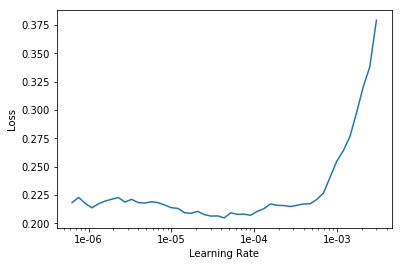

In [42]:
learn.recorder.plot()

This will plot the result of our LR finder and what this basically shows you is this key parameter called a learning rate. The learning rate basically says how quickly am I updating the parameters in my model. The x-axis one here shows me what happens as I increase the learning rate. The y axis show what the loss is. 

So you can see, once the learning rate gets passed 10^-4, my loss gets worse. It actually so happens, in fact I can check this if I press <kbd>shift</kbd>+<kbd>tab</kbd> here, my learning defaults to 0.003. So you can see why our loss got worse. Because we are trying to fine-tune things now, we can't use such a high learning rate. 

So based on the learning rate finder, I tried to pick something well before it started getting worse. So I decided to pick `1e-6`. But there's no point training all the layers at that rate, because we know that the later layers worked just fine before when we were training much more quickly. 

So what we can actually do is we can pass a range of learning rates to `learn.fit_one_cycle`. 

You use this keyword in Python called `slice` and that can take a start value and a stop value and basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that (i.e. between those two values equally). 

In [43]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.226834,0.237927,0.076455,00:39
1,0.208640,0.233402,0.073748,00:40


In [44]:
# 2 more epochs to see if we can improve

learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.187846,0.235125,0.076455,00:40
1,0.178717,0.230367,0.072395,00:40


There are improvements, but not as much as he's getting in the video

A good rule of thumb is after you unfreeze (i.e. train the whole thing), pass a max learning rate parameter, pass it a slice, make the second part of that slice about 10 times smaller than your first stage. 

Our first stage defaulted to about 1e-3 so it's about 1e-4. And the first part of the slice should be a value from your learning rate finder which is well before things started getting worse. So you can see things are starting to get worse maybe about here:

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson1/128.png'/>

So I picked something that's at least 10 times smaller than that.

If I do that, then the error rate gets a bit better. So I would perhaps say for most people most of the time, these two stages are enough to get pretty much a world-class model. You won't win a Kaggle competition, particularly because now a lot of fastai alumni are competing on Kaggle and this is the first thing that they do. 

But in practice, you'll get something that's about as good in practice as the vast majority of practitioners can do. 

# Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. 

#### We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


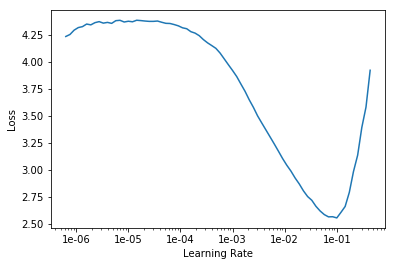

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [ ]:
learn.save('res50-stage-1')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('res50-stage-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

# Other data formats and how to label your DataBunch

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE, dest=datapath); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

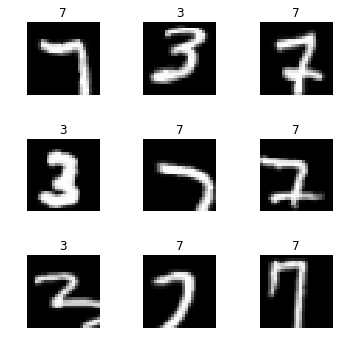

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

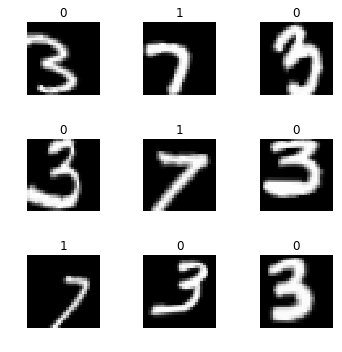

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']